In [27]:
#importing libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords
import re

In [28]:
# creating a conenction to the database
conn = sqlite3.connect('reddit-posts.db')
cursor = conn.cursor()

In [29]:
# SQL query to get a list of all tables in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"

# Execute the query
cursor.execute(query)

# Fetch all the results
tables = cursor.fetchall()

# Print the tables
for table in tables:
    print(table[0])


posts


In [30]:
#converting data into a pandas dataframe
airlines = pd.read_sql_query('SELECT * FROM posts', conn)
print(airlines.shape)
airlines.head()

(250, 9)


,id,title,body,score,author,data,url,sentiment,airline
0,133bh0h,Frontier Baggage Scam,Literally saw something I have never seen in a...,173,kniedrist,1.682815e+09,None,negative,Frontier
1,10bx7c4,Small Claims Court is Great for Air Travel Dis...,"Hi everyone, recently I flew Turkish to Ethiop...",140,[deleted],1.673725e+09,None,negative,Air Travel
2,f0qq9o,Just Had an Older Woman Try to Take My Seat,In India on Airline Indigo. I see a middle-age...,117,ReallyWeirdNormalGuy,1.581163e+09,None,negative,IndiGo
3,12hj4k4,Has anyone experienced this?,TLDR: Norse Atlantic Airways told me my person...,63,Previous_Remove1991,1.681134e+09,https://v.redd.it/x5r5o1yfq3ta1,negative,Atlantic Airways
4,f2amsb,A couple of tips/tools for finding cheap Busin...,Every day I search premium flight deals for ot...,61,Flawingo,1.581438e+09,None,positive,LOT


In [31]:
#Checking the number of airlines in the dataset
airlines['airline'].value_counts()

LOT                  21
Frontier             17
easyJet              15
American Airlines    14
Air Canada           13
                     ..
Asiana Airlines       1
EVA Air               1
Lift                  1
Air Greenland         1
Austrian Airlines     1
Name: airline, Length: 71, dtype: int64

In [32]:
#totalling the sentiment analysis results
sent_summary = airlines['sentiment'].value_counts()
sent_summary

negative    162
neutral      76
positive     12
Name: sentiment, dtype: int64

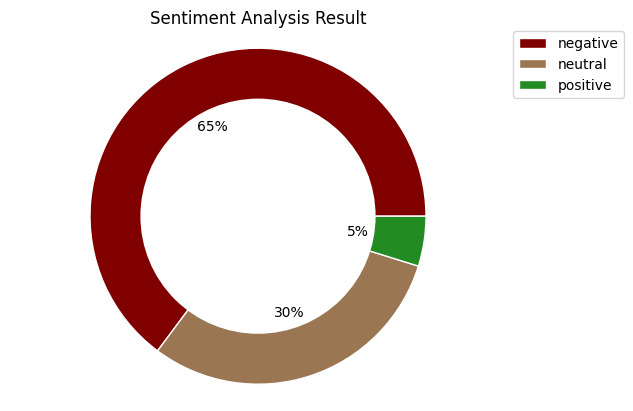

In [33]:
import matplotlib.pyplot as plt

# Compiling the results into a pie chart
colors = ['#800000', '#9b7653', '#228B22']  # Custom colors for the pie slices

# Create the figure and axes objects
fig, ax = plt.subplots()

# Plot the pie chart
sent_summary.plot(kind='pie', y='score', autopct='%1.0f%%',
                  colors=colors, ylabel='', labeldistance=None,
                  ax=ax, wedgeprops={'linewidth': 1, 'edgecolor': 'white'})

# Set the title and legend
ax.set_title('Sentiment Analysis Result')
ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

# Add a white circle at the center to create a donut-like appearance
center_circle = plt.Circle((0, 0), 0.7, fc='white')
ax.add_patch(center_circle)

# Set the aspect ratio to be equal to make the pie chart circular
ax.axis('equal')

# Remove unnecessary spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='both', length=0)

plt.show()


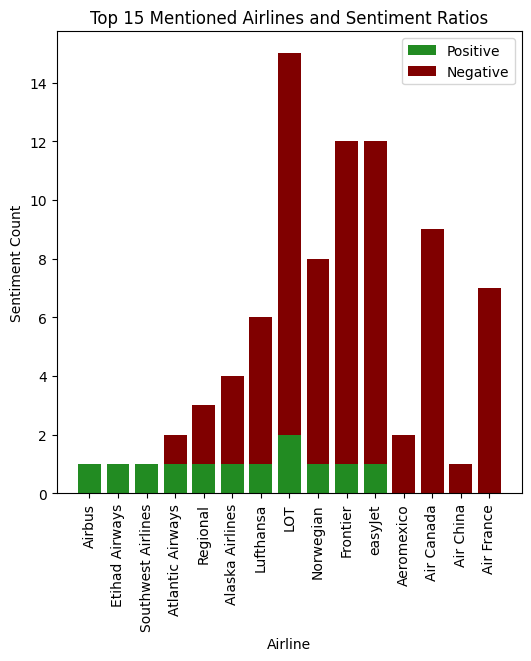

In [41]:
#Creating a positive to negative sentiment ratio for each airline
sentiment_counts = airlines.groupby(['airline', 'sentiment']).size().unstack(fill_value=0)
sentiment_counts['Sentiment_Ratio'] = sentiment_counts['positive'] / sentiment_counts['negative']
sentiment_counts = sentiment_counts.reset_index()
top_15_airlines = sentiment_counts.nlargest(15, 'Sentiment_Ratio')

#Displaying the ratio of positive to negative sentiments for each airline
plt.figure(figsize=(6, 6))
plt.bar(top_15_airlines['airline'], top_15_airlines['positive'], label='Positive', color='#228B22')
plt.bar(top_15_airlines['airline'], top_15_airlines['negative'], bottom=top_15_airlines['positive'], 
        label='Negative', color='#800000')

plt.xlabel('Airline')
plt.ylabel('Sentiment Count')
plt.title('Top 15 Mentioned Airlines and Sentiment Ratios')
plt.xticks(rotation=90)
plt.legend()
plt.show()

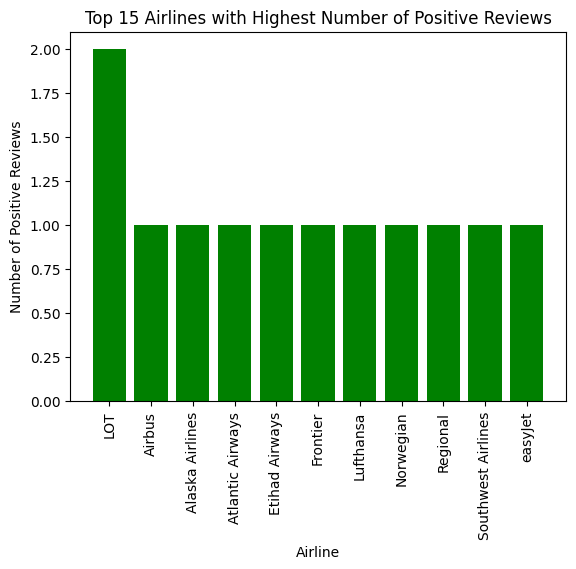

In [42]:
# Displaying airlines with highest number of positive sentiments
positive_df = airlines[airlines['sentiment'] == 'positive']
positive_sentiment_counts = positive_df.groupby('airline').size().reset_index(name='Positive_Count')
top_15_positive_airlines = positive_sentiment_counts.nlargest(15, 'Positive_Count')
plt.bar(top_15_positive_airlines['airline'], top_15_positive_airlines['Positive_Count'], color='green')

plt.xlabel('Airline')
plt.ylabel('Number of Positive Reviews')
plt.title('Top 15 Airlines with Highest Number of Positive Reviews')
plt.xticks(rotation=90)


plt.show()

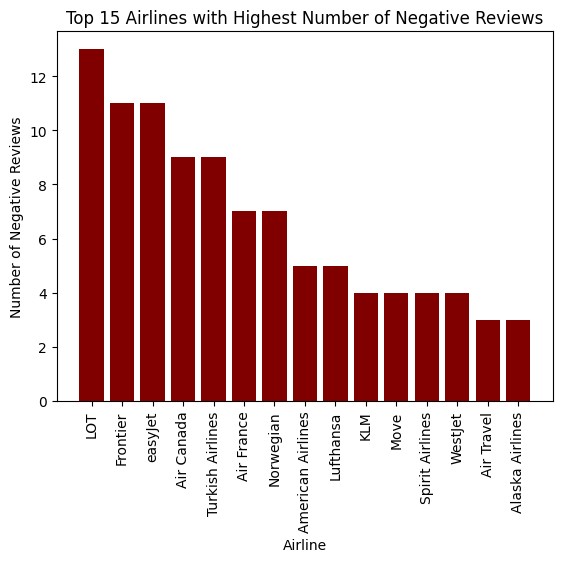

In [44]:
# Displaying airlines with highest number of negative sentiments
negative_df = airlines[airlines['sentiment'] == 'negative']
negative_sentiment_counts = negative_df.groupby('airline').size().reset_index(name='Negative_Count')
top_15_negative_airlines = negative_sentiment_counts.nlargest(15, 'Negative_Count')
plt.bar(top_15_negative_airlines['airline'], top_15_negative_airlines['Negative_Count'], color='#800000')

plt.xlabel('Airline')
plt.ylabel('Number of Negative Reviews')
plt.title('Top 15 Airlines with Highest Number of Negative Reviews')
plt.xticks(rotation=90)


plt.show()

In [35]:
#Simple Pre-processing
def preProcess(dataset, column):
    dataset[column] = dataset[column].map(lambda x: re.sub('[,\.!?]', '', x))
    dataset[column] = dataset[column].str.lower()
    return dataset[column]

airlines['body'] = preProcess(airlines, 'body')



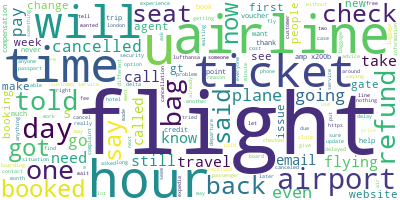

In [36]:
#Creating a Wordcloud of the most common words our data set
long_string = ','.join(list(airlines['body'].values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

### Performing LDA

In [37]:
# Vectorize document using TF-IDF
stop_words= stopwords.words('english')
stop_words.extend(['from', 'amp x200b', 'x200b', 've', 'just', 'u','would'])

tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=stop_words,
                        ngram_range = (1,2))

# Changing series to list and replacing NaN with empty strings
airlines['body'] = airlines['body'].map(lambda x: x.lower())
air_list = airlines['body'].fillna('').to_list()

# Fit and Transform the documents
train_data = tfidf.fit_transform(air_list) 

/usr/local/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['amp'] not in stop_words.
  warnings.warn(


In [38]:
# Define the number of topics or components
num_components=3

# Create LDA object
model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
lda_matrix = model.fit_transform(train_data)

# Get Components 
lda_components=model.components_

In [39]:
# Print the topics with their terms
feature_names = tfidf.get_feature_names_out()

for index, component in enumerate(lda_components):
    zipped = zip(feature_names, component)
    top_terms_key = sorted(zipped, key=lambda t: t[1], reverse=True)[:10]
    top_terms_list = [term for term, _ in top_terms_key] 
    print("Topic " + str(index) + ": ", top_terms_list)

Topic 0:  ['flight', 'us', 'get', 'seat', 'amp', 'told', 'flights', 'hours', 'airport', 'email']
Topic 1:  ['flight', 'get', 'flying', 'time', 'new', 'baggage', 'us', 'refund', 'passport', 'airlines']
Topic 2:  ['flight', 'us', 'flights', 'lufthansa', 'airline', 'hours', 'credit', 'airlines', 'time', 'ticket']


In [40]:
cursor.close()
conn.close()